# Calibration measurment of S-adenosylmethionine (SAM) using UV-Vis spectroscopy

In the following example, we will use the defined data mode for a `Calibration` to make a structured data set, containing data and metadata of a photometric calibration experiment for S-Adenosyl methionine.  

<img src=https://upload.wikimedia.org/wikipedia/commons/thumb/7/7c/S-adenosyl_methionine.png/2880px-S-adenosyl_methionine.png width="250">


The metadata includes:
- `name` of the analyte
- `inchi` code of the analyte
- `ph` of the measurement
- `temperature` of the measurement
- `temperature_unit` of the measurement
- `wavelength` of detection

The data comprises:
- known `concentration` of the analyte
- `conc_unit` of the concentration
- measured `signal` of the analyte

In the first step, the data is loaded from the file, which was generated by the photometer which was used to measure the signal of the samples.

In [1]:
# notebook setup
import sys

IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !git clone https://github.com/FOR5596/data-model-example.git
    %cd data-model-example
    !pip install  -q -r requirements.txt
    %reset -f

from sdRDM import DataModel
from pandas import read_csv
from scipy.stats import linregress
import matplotlib.pyplot as plt

## 1. Load the Research Data Model, load the data

In the following cell, the defined data model is loaded as a Python class.

In [2]:
model = DataModel.from_markdown("calibration-data-model.md")

Simulated absorption data is in the file `data.csv`, which is loaded in the following cell.

In [3]:
data = read_csv("data.csv", header=0, index_col=0)
data

,Concentration µmol/l,Signal 260nm
0,0.0,0.003499
1,20.0,0.343499
2,40.0,0.683499
3,60.0,1.023499
4,80.0,1.363499
5,100.0,1.703499
6,120.0,2.043499
7,140.0,2.383499
8,160.0,2.723499
9,180.0,3.063499


## Create a `Calibration` object

In the following cell, all meta data is manually defined, while a `Calibration` object is created.

### Add metadata

In [4]:
sam_calibration = model.Calibration(
    analyte_name="S-Adenosyl methionine",
    date_measured="2024-02-25 19:25:40",
    inchi="InChI=1S/C15H22N6O5S/c1-27(3-2-7(16)15(24)25)4-8-10(22)11(23)14(26-8)21-6-20-9-12(17)18-5-19-13(9)21/h5-8,10-11,14,22-23H,2-4,16H2,1H3,(H2-,17,18,19,24,25)/p+1/t7?,8-,10-,11-,14-,27?/m1/s1",
    ph=7.4,
    temperature=37,
    temperature_unit="C",
    wavelength=260,
)
print(sam_calibration)

Calibration
├── id = e62c2d05-c492-4a45-a2dc-31a47baac3a2
├── analyte_name = S-Adenosyl methionine
├── inchi = InChI=1S/C15H22N6O5S/c1-27(3-2-7(16)15(24)25)4-8-10(22)11(23)14(26-8)21-6-20-9-12(17)18-5-19-13(9)21/h5-8,10-11,14,22-23H,2-4,16H2,1H3,(H2-,17,18,19,24,25)/p+1/t7?,8-,10-,11-,14-,27?/m1/s1
├── date_measured = 2024-02-25 19:25:40
├── temperature = 37.0
├── temperature_unit
│   └── Unit
│       ├── id = ff5ba78d-fcd8-4db0-9093-0ffd44a739cd
│       ├── name = C
│       └── bases
│           └── 0
│               └── BaseUnit
│                   ├── scale = 1.0
│                   ├── kind = A
│                   └── exponent = 1.0
├── ph = 7.4
└── wavelength = 260.0



### Add Data

In [5]:
# Extract concentration unit from the column name
conc_unit = data.columns[0].split(" ")[1]

# Add the data of each row to individual `Samples`
for row in data.iterrows():
    concentration, signal = row[1].values
    sam_calibration.add_to_samples(
        init_conc=concentration,
        conc_unit=conc_unit,
        measured_signal=signal,
    )

print(sam_calibration)

Calibration
├── id = e62c2d05-c492-4a45-a2dc-31a47baac3a2
├── analyte_name = S-Adenosyl methionine
├── inchi = InChI=1S/C15H22N6O5S/c1-27(3-2-7(16)15(24)25)4-8-10(22)11(23)14(26-8)21-6-20-9-12(17)18-5-19-13(9)21/h5-8,10-11,14,22-23H,2-4,16H2,1H3,(H2-,17,18,19,24,25)/p+1/t7?,8-,10-,11-,14-,27?/m1/s1
├── date_measured = 2024-02-25 19:25:40
├── temperature = 37.0
├── temperature_unit
│   └── Unit
│       ├── id = ff5ba78d-fcd8-4db0-9093-0ffd44a739cd
│       ├── name = C
│       └── bases
│           └── 0
│               └── BaseUnit
│                   ├── scale = 1.0
│                   ├── kind = A
│                   └── exponent = 1.0
├── ph = 7.4
├── samples
│   ├── 0
│   │   └── Sample
│   │       ├── id = e47f6d4c-50e1-4f12-8a42-ce2924831a05
│   │       ├── init_conc = 0.0
│   │       ├── conc_unit
│   │       │   └── Unit
│   │       │       ├── id = a78a1c0b-4c2c-4d5c-8000-d72215788aa4
│   │       │       ├── name = umol / l
│   │       │       └── bases
│   │       │           

## Analyze the data

In this section the data is analyzed. In the first step, the data is plotted to visualize the relationship between the concentration and the signal. In the second step, a linear regression is performed to calculate the slope and the intercept of the calibration curve.

### Plot the data

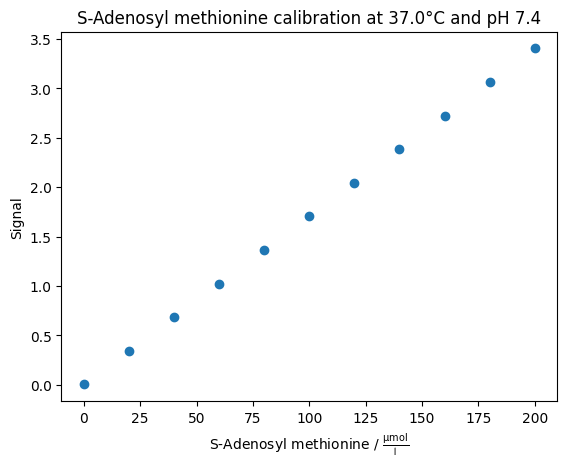

In [6]:
# Extract data from the the `Calibration` object
concentrations = sam_calibration.get("samples/init_conc")
unit = sam_calibration.get("samples/conc_unit")
signals = sam_calibration.get("samples/measured_signal")

# Plot the calibration data of all samples
plt.scatter(x=concentrations, y=signals)
plt.ylabel("Signal")
plt.xlabel(
    f"{sam_calibration.analyte_name} / {unit[0]._unit.to_string(format='latex')}"
)
plt.title(
    f"{sam_calibration.analyte_name} calibration at {sam_calibration.temperature}°C and pH {sam_calibration.ph}"
)

plt.show()

### Linear regression

In [7]:
# Calculate the slope of the calibration curve
slope = linregress(concentrations, signals).slope

# Add the result to the `met_calibration` object
sam_calibration.slope = slope

## Safe Data

To safe the `Calibration` object to a file, the `to_file` method is used.

In [8]:
with open("sam_calibration.json", "w") as f:
    f.write(sam_calibration.json())

/Users/max/miniconda3/envs/data-model-example/lib/python3.12/site-packages/sdRDM/base/datamodel.py:359: UserWarning: No 'URL' and 'Commit' specified. This model might not be re-usable.
  warnings.warn(
